In [307]:
from skimage.measure import find_contours
from skimage.feature import corner_harris, corner_peaks, canny 
from skimage.draw import polygon, circle_perimeter, line, disk
from skimage.filters.thresholding import threshold_otsu, threshold_local
from skimage.filters._median import median
from skimage.filters import gaussian
from skimage.morphology.binary import binary_dilation, binary_erosion , binary_closing, binary_opening
from skimage.morphology import skeletonize
from skimage.transform.hough_transform import hough_circle, hough_circle_peaks, hough_line, hough_line_peaks
from skimage.color import rgb2gray
import skimage.io as io
import numpy as np
import cv2
import matplotlib.pyplot as plt
from Preproccesing_Custom_Functions import *
from collections import Counter
from scipy import stats
from PIL import Image
from commonfunctions import *
from pathlib import Path
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from skimage.io import imread
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
import os
import warnings





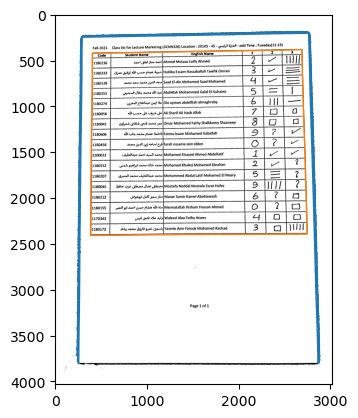

In [545]:

# Load the image
i=8
# sample_image_rgb = io.imread('grade sheet/gradesheet/310931d4-cd80-49f7-88b4-0862acc06097.jpg')
# sample_image_rgb = io.imread('grade sheet\gradesheet\c0747b4e-a551-4532-b97a-2155d4696cd6.jpg')
# sample_image_rgb = io.imread('grade sheet\gradesheet/bff4906c-c00c-43e6-8660-d5b8350fcddd.jpg')
# sample_image_rgb = io.imread('grade sheet/gradesheet/IMG_6241.jpg')
sample_image_rgb = io.imread(f'grade sheet/{i}.jpg')

flag = False

sample_image_gray = rgb2gray(sample_image_rgb)
thresh = threshold_local(sample_image_gray, block_size=101,offset=0.1, method='gaussian')
sample_image_gray = sample_image_gray > thresh
# Find the contours
threshold_rel= ((sample_image_gray.max()+sample_image_gray.min())/2)*1.25

while True:
      Contours=find_contours(sample_image_gray, threshold_rel)
      # Sort the contours by area
      Contours = sorted(Contours, key=Get_Contour_Area, reverse=True)
      Paper_Contour= Contours[0] # The largest contour is the paper contour, the second largest contour is the bubble contour
      Inner_Contour= Contours[1]
      Ratio=Get_Contour_Area(Paper_Contour)/Get_Contour_Area(Inner_Contour)
      if Ratio < 1.4 or Ratio> 8:
                  sample_image_gray  = rgb2gray(sample_image_rgb)
                  flag= True
                  threshold_rel*=0.9
      else:     
            break


# Display the image and plot the largest 2 contours found
fig, ax = plt.subplots()
ax.imshow(sample_image_gray, cmap=plt.cm.gray)

for i in range(2):
      ax.plot(Contours[i][:, 1], Contours[i][:, 0], linewidth=1)

ax.axis('image')
plt.show()



In [546]:
Inner_Contour = np.flip(Inner_Contour, axis=1) # Flip the contour to match the image coordinates
# Extract the corners of the paper contour
Top_Left = sorted(Inner_Contour, key= lambda x: x[0]+x[1])[0]
Top_Right = sorted(Inner_Contour, key= lambda x: x[0]-x[1])[-1]
Bottom_Left = sorted(Inner_Contour, key= lambda x: x[0]-x[1])[0]
Bottom_Right = sorted(Inner_Contour, key= lambda x: x[0]+x[1])[-1]

Corners=np.array([Top_Left,Top_Right,Bottom_Left,Bottom_Right])


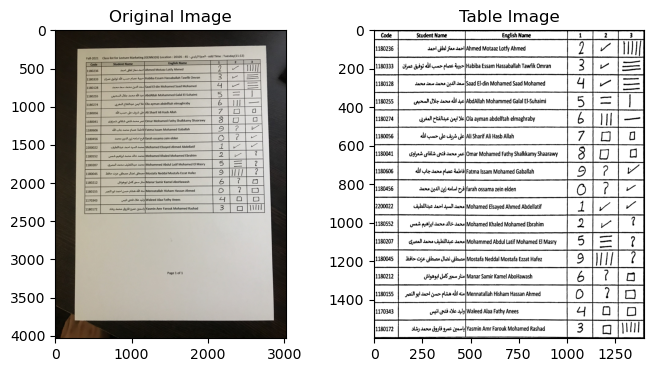

In [547]:
# Using the 4 corners of the contour, warp the image to a rectangle
size_multiplier = 5
width,height = 280*size_multiplier, 320*size_multiplier # The width and height of the final image

img= (255*sample_image_gray).astype(np.uint8)


pts1 = np.float32([Corners[0], Corners[1], Corners[2], Corners[3]]) # The 4 corners of the contour
pts2= np.float32([[0,0],[width,0],[0,height],[width,height]]) # The corners of the final image
matrix = cv2.getPerspectiveTransform(pts1,pts2) # The transformation matrix
result = cv2.warpPerspective(img,matrix,(width,height)) # The warped image
io.imsave(f'result{i}.jpg', result)

fig, (ax,ax1) = plt.subplots(ncols=2 , figsize=(8, 4))
ax.imshow(sample_image_rgb, cmap=plt.cm.gray)
ax.set_title('Original Image')
ax1.imshow(result, cmap=plt.cm.gray)
ax1.set_title('Table Image')
plt.show
Gray_Img = result


In [548]:
binary = result
if flag is True: # Threshold if not already thresholded.
    thresh = threshold_local(result, block_size=101,offset=15, method='gaussian', param=20)
    binary = result > thresh
io.imsave("binary_local.jpg", binary)

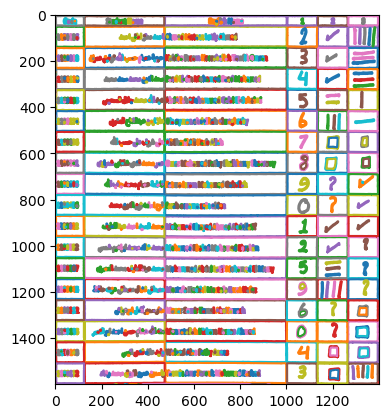

In [549]:
# If we try to find the contours initially, we get a lot of irrelevent contours.
Cells= find_contours(binary)
fig,ax = plt.subplots()
ax.imshow(binary,cmap=plt.cm.gray)

Cells=sorted(Cells, key=Get_Contour_Area, reverse=True)
for cell in Cells:
    ax.plot(cell[:,1],cell[:,0])
    

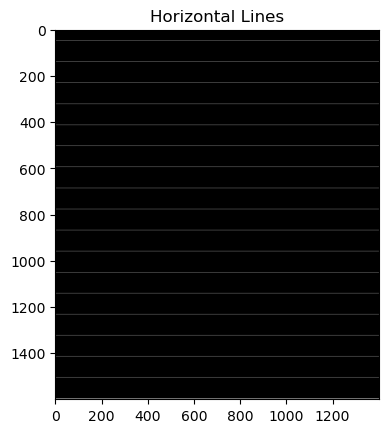

In [550]:
# Instead, we shall reconstruct the table by finding the horizontal and vertical lines first.
# Detect the horizontal lines through repeated binary erosion dilation
length = binary.shape[1]//10
horizontal_kernel = np.ones((1,length), np.uint8)
Horizontal_Image= ~binary.copy()

# Erosion yields only the horizontal lines and removes the noise.
for i in range(2): Horizontal_Image = binary_erosion(Horizontal_Image, horizontal_kernel)

# The resulting lines are choppy, so we dilate them to get the full lines.
for i in range(30): Horizontal_Image = binary_dilation(Horizontal_Image, horizontal_kernel)

# Some lines are detected twice, so we remove them. and add a line in between the two lines.

Min_Distance= 30
Y1=0
Y2=0


# Remove double detected lines

for i in range(Horizontal_Image.shape[0]): # In range of the height of the image
    if Horizontal_Image[i,0]==1 and Y1==0: # If a line is detected and Y1 is not set
        Y1=i # Set Y1 to the current line
        continue
    
    if Horizontal_Image[i,0]==1 and Y1!=0: # If a line is detected and Y1 is set
        Y2=i # Set Y2 to the current line
        z=Y2 
        
        if Y2-Y1 < Min_Distance: # If the distance between the two lines is less than the minimum distance
            while Horizontal_Image[z,0]==1: # While the next row is a line
                z+=1 # Increment z
                if z==Horizontal_Image.shape[0]: break # If z is out of bounds, break
                
            Horizontal_Image[Y1:Y1+Min_Distance,:]=0 # Remove the first line
            Horizontal_Image[(Y1+z)//2,:]=1 # Add a line in between the two lines
        Y1=Y2
        Y2= 0

    

# Adjust the edge borders
Horizontal_Image[:40,:]=0
Horizontal_Image[-40:,:]=0
Horizontal_Image[:2,:]=1
Horizontal_Image[-2:,:]=1

fig,ax = plt.subplots()
ax.imshow(Horizontal_Image,cmap=plt.cm.gray)
ax.set_title("Horizontal Lines")
plt.show()

In [551]:
# Count the horizontal lines --> rows = Lines+1
# Remove the edges of the image to prevent false positives

Row_Num=len(find_contours(Horizontal_Image))//2

print(f'There are {Row_Num} rows')


There are 18 rows


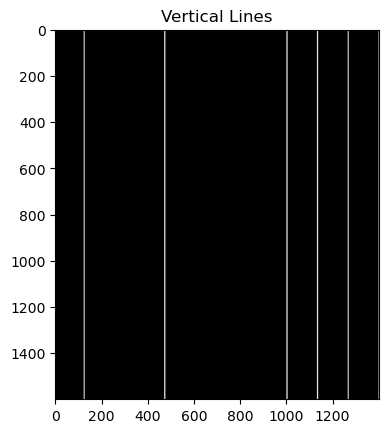

In [552]:
# Detect the vertical lines through repeated binary erosion and dilation
vertical_kernel = np.ones((length,1), np.uint8)
Vertical_Image= ~binary.copy()

# Erosion yields only the vertical lines and removes the cell contents.
for i in range(3): Vertical_Image = binary_erosion(Vertical_Image, vertical_kernel)
# Dilation extends the lines to get the full lines.
for i in range(30): Vertical_Image = binary_dilation(Vertical_Image, vertical_kernel)

# Sometimes the lines representing the borders of the table are not detected. Other times they are detected.
# To solve this we remove the lines that are too close to the borders of the image.
# Remove the edge borders
Vertical_Image[:,0:40]=0
Vertical_Image[:,-40:]=0

# Then we consider the borders of the image as the borders of the table.
Vertical_Image[:,0:2]=1
Vertical_Image[:,-2:]=1


fig,ax = plt.subplots()
ax.imshow(Vertical_Image,cmap=plt.cm.gray)
ax.set_title("Vertical Lines")
plt.show()


In [553]:
# Count the vertical lines --> Columns = Lines-1
Col_Num=len(find_contours(Vertical_Image))//2

print(f'There are {Col_Num} columns')


There are 6 columns


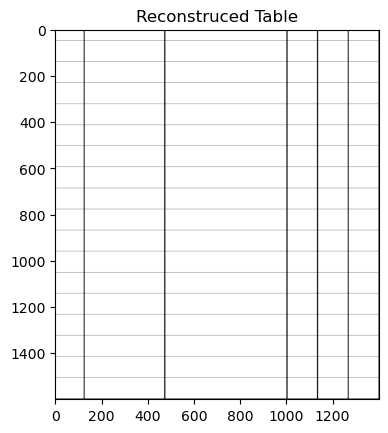

In [554]:
Reconstructed_Image = Horizontal_Image | Vertical_Image
Reconstructed_Image = ~Reconstructed_Image


fig,ax = plt.subplots()
ax.imshow(Reconstructed_Image,cmap=plt.cm.gray)
ax.set_title("Reconstruced Table")
plt.show()


Number of cells found: 108
Number of cells expected: 108


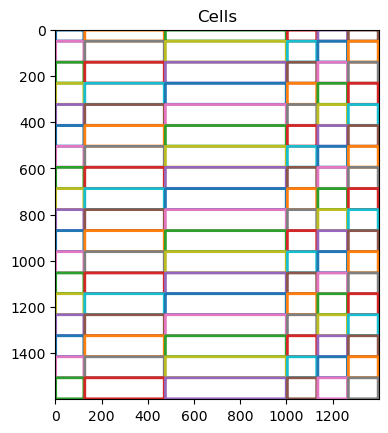

In [555]:
# Find the contours of the reconstructed image
Contours = find_contours(Reconstructed_Image)
Cells= []
# Flip the contours to match the image coordinates since the contours are in (y,x) format
Contours = [np.flip(contour, axis=1) for contour in Contours]

# Filter out the contours that are not cells by their height (Small contours found at the edges of the image between the table and the paper)
for cell in Contours:
    Top_Left, _, Bottom_Left, _ = Get_Corners(cell)
    cell_height = abs(Top_Left[1]-Bottom_Left[1])
    if cell_height < 30:
        continue
    else:
        Cells.append(cell)

Cells = [np.flip(cell, axis=1) for cell in Cells]


print(f"Number of cells found: {len(Cells)}")
print(f"Number of cells expected: {Row_Num*Col_Num}")

fig, ax = plt.subplots()
ax.imshow(Reconstructed_Image, cmap=plt.cm.gray)
ax.set_title('Cells')
for contour in Cells:
    ax.plot(contour[:,1], contour[:,0], linewidth=2)

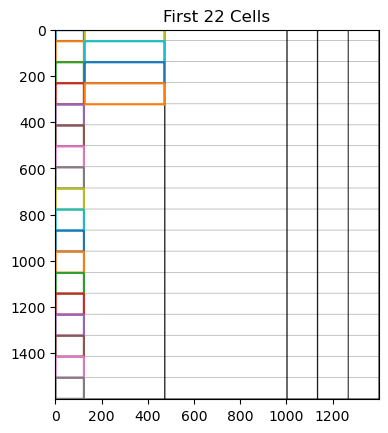

In [556]:
# Now we sort the contours from top to bottom
Cells = sorted(Cells, key= lambda x: x[0][1])

# Plot the contours
k= Row_Num+4
fig, ax = plt.subplots()
ax.imshow(Reconstructed_Image, cmap=plt.cm.gray)
ax.set_title(f'First {k} Cells')
for contour in Cells[:k]:
    ax.plot(contour[:,1],contour[:,0])


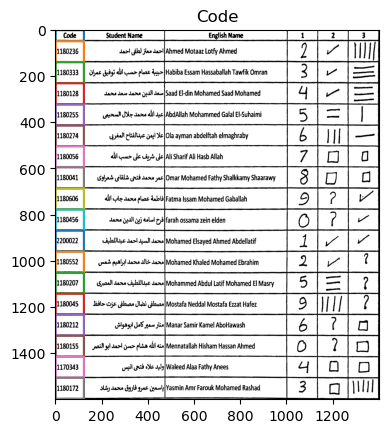

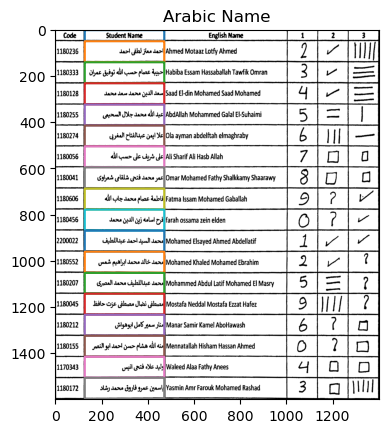

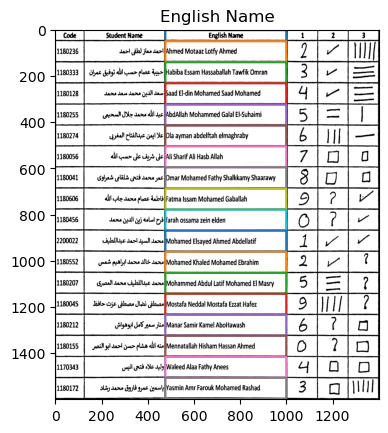

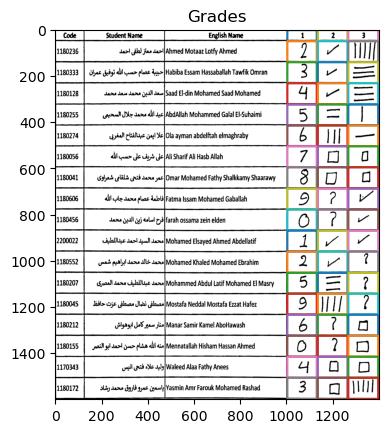

In [557]:
# Student Code Contours
Student_Codes = Cells[:Row_Num]
Student_Names_Arabic = Cells[Row_Num:2*Row_Num]
Student_Names_English = Cells[2*Row_Num:3*Row_Num]
Grades=np.zeros([Col_Num-3, Row_Num],dtype=np.ndarray)

for Col in range(Col_Num-3):
    for Row in range(Row_Num):
        Grades[Col][Row]= Cells[(Col_Num-3+Col)*Row_Num+Row]

#==============================================================================        
# Plots
#==============================================================================
        
fig,ax1= plt.subplots()
ax1.imshow(binary,cmap=plt.cm.gray)
ax1.set_title("Code")
for contour in Student_Codes:
    ax1.plot(contour[:,1],contour[:,0])

fig,ax1= plt.subplots()
ax1.imshow(binary,cmap=plt.cm.gray)
ax1.set_title("Arabic Name")
for contour in Student_Names_Arabic:
    ax1.plot(contour[:,1],contour[:,0])

fig,ax1= plt.subplots()
ax1.imshow(binary,cmap=plt.cm.gray)
ax1.set_title("English Name")
for contour in Student_Names_English:
    ax1.plot(contour[:,1],contour[:,0])

fig,ax1= plt.subplots()
ax1.imshow(binary,cmap=plt.cm.gray)
ax1.set_title("Grades")
for column in Grades:
    for contour in column:
        ax1.plot(contour[:,1],contour[:,0])


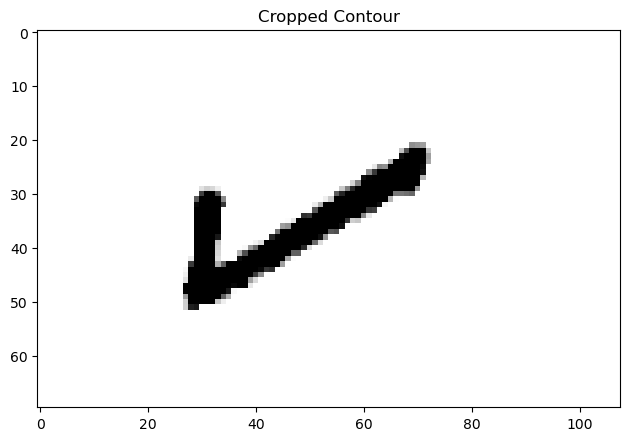

In [558]:
fig,ax1= plt.subplots()
ax1.imshow(binary,cmap=plt.cm.gray)
ax1.set_title("Cropped Contour")
row=2
col=1
ax1.plot(Grades[col,row][:,1],Grades[col,row][:,0])

Corners = Get_Corners(Grades[col,row]).astype(int)
Xmin = np.min(Corners,axis=0)[0]+10
Xmax = np.max(Corners,axis=0)[0]-10
Ymin = np.min(Corners,axis=0)[1]+10
Ymax = np.max(Corners,axis=0)[1]-10

# Crop the image
Cropped_Image = binary[Xmin:Xmax,Ymin:Ymax]
io.imshow(Cropped_Image)


There are 0 vertical lines


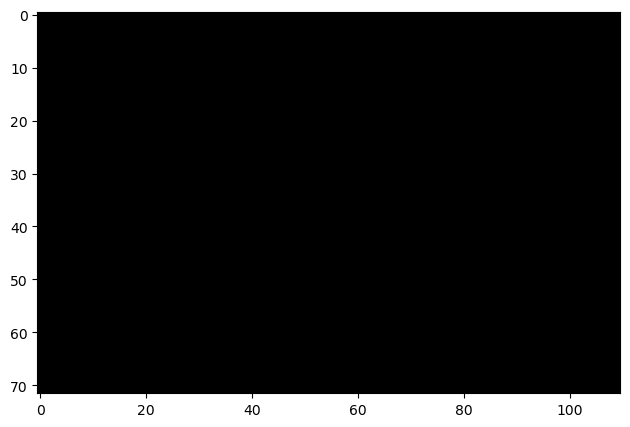

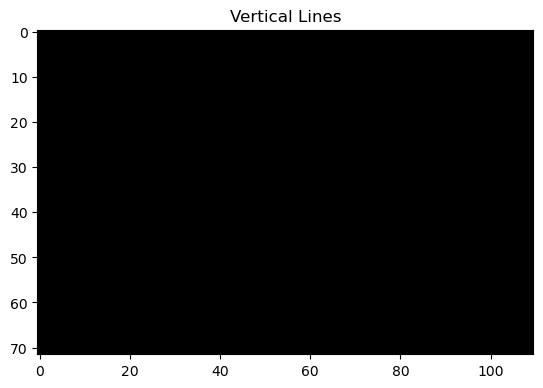

In [559]:
# Detect the vertical lines through repeated binary erosion and dilation
length = Cropped_Image.shape[1]//10
vertical_kernel = np.ones((length,1), np.uint8)
Vertical_Image= ~Cropped_Image.copy()

# Erosion yields only the vertical lines and removes the cell contents.
for i in range(4): Vertical_Image = binary_erosion(Vertical_Image, vertical_kernel)
# Dilation extends the lines to get the full lines.
for i in range(30): Vertical_Image = binary_dilation(Vertical_Image, vertical_kernel)
# Add a 1 pixel black border
Vertical_Image = np.pad(Vertical_Image, 1, mode='constant', constant_values=0)

io.imshow(Vertical_Image)

# Count the vertical lines --> Columns = Lines-1
VLines=len(find_contours(Vertical_Image))
print(f'There are {VLines} vertical lines')

# plot the contours
fig,ax1= plt.subplots()
ax1.imshow(Vertical_Image,cmap=plt.cm.gray)
ax1.set_title("Vertical Lines")
Contours = find_contours(Vertical_Image)
for contour in Contours:
    ax1.plot(contour[:,1],contour[:,0])



There are 0 horizontal lines


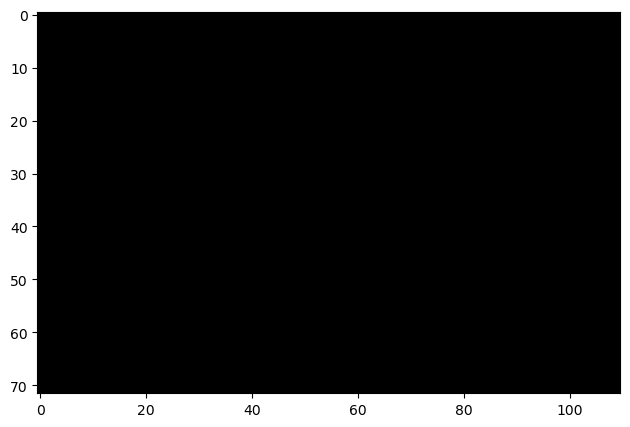

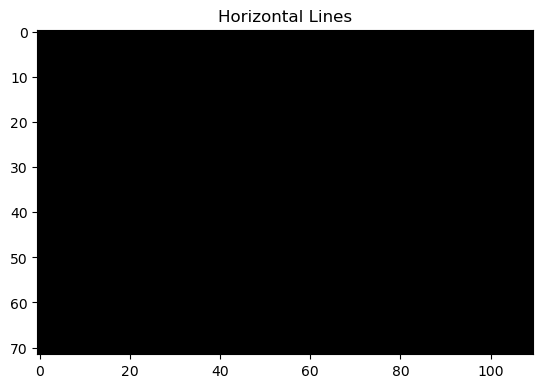

In [560]:
# Detect the horizontal lines through repeated binary erosion and dilation
length = Cropped_Image.shape[1]//10
horizontal_kernel = np.ones((1,length), np.uint8)
Horizontal_Image= ~Cropped_Image.copy()

# Erosion yields only the vertical lines and removes the cell contents.
for i in range(4): Horizontal_Image = binary_erosion(Horizontal_Image, horizontal_kernel)
# Dilation extends the lines to get the full lines.
for i in range(30): Horizontal_Image = binary_dilation(Horizontal_Image, horizontal_kernel)

Horizontal_Image = np.pad(Horizontal_Image, 1, mode='constant', constant_values=0)

io.imshow(Horizontal_Image)
Contours = find_contours(Horizontal_Image)
HLines=len(Contours)//2
print(f'There are {HLines} horizontal lines')

# plot the contours
fig,ax1= plt.subplots()
ax1.imshow(Horizontal_Image,cmap=plt.cm.gray)
ax1.set_title("Horizontal Lines")

for contour in Contours:
    ax1.plot(contour[:,1],contour[:,0])




As KNN struggles to handle stacked lines, we will use a different approach.

Before we attempt to predict the output with KNN, we first attempt to filter out the stacked lines and count them.

There are 0 vertical
There are 0 horizontal lines

There are 0 vertical
There are 0 horizontal lines

There are 0 vertical
There are 0 horizontal lines

There are 0 vertical
There are 2 horizontal lines

There are 3 vertical
There are 0 horizontal lines

There are 2 vertical
There are 2 horizontal lines

There are 2 vertical
There are 2 horizontal lines

There are 0 vertical
There are 1 horizontal lines

There are 0 vertical
There are 1 horizontal lines

There are 0 vertical
There are 0 horizontal lines

There are 0 vertical
There are 0 horizontal lines

There are 0 vertical
There are 3 horizontal lines

There are 4 vertical
There are 0 horizontal lines

There are 0 vertical
There are 1 horizontal lines

There are 0 vertical
There are 1 horizontal lines

There are 2 vertical
There are 2 horizontal lines

There are 2 vertical
There are 2 horizontal lines

[(1, 4), (1, 5), (1, 8), (1, 9), (1, 12), (1, 13), (1, 14), (1, 15)]
8
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 3 3 0 0 4 4 0

C:\Users\Karim Negm\AppData\Local\Temp\ipykernel_3432\3294742914.py:71: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,(ax1,ax2)= plt.subplots(ncols=2,figsize=(10,10))


There are 0 vertical
There are 0 horizontal lines

There are 0 vertical
There are 0 horizontal lines

There are 0 vertical
There are 0 horizontal lines

There are 1 vertical
There are 0 horizontal lines

There are 0 vertical
There are 1 horizontal lines

There are 1 vertical
There are 1 horizontal lines

There are 2 vertical
There are 2 horizontal lines

There are 2 vertical
There are 2 horizontal lines

There are 2 vertical
There are 2 horizontal lines

There are 5 vertical
There are 0 horizontal lines

[(1, 4), (1, 5), (1, 8), (1, 9), (1, 12), (1, 13), (1, 14), (1, 15), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 11), (2, 12), (2, 17)]
16
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 3 3 0 0 4 4 0 0 2 4 4 4 0 0]
 [0 5 2 2 1 4 0 0 0 0 0 1 4 0 0 0 0 5]]


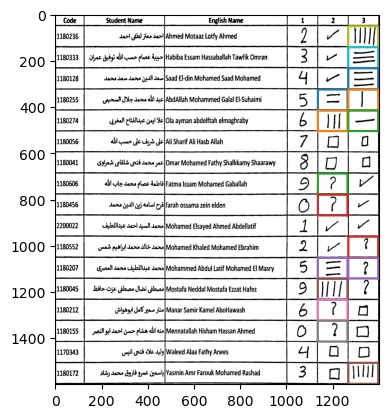

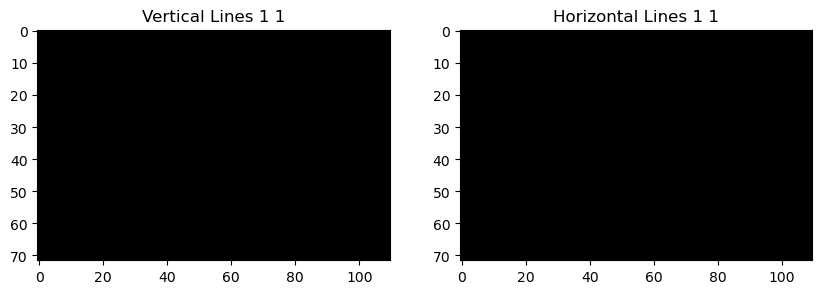

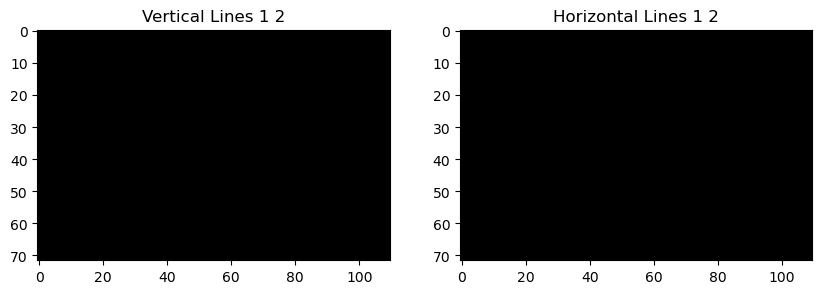

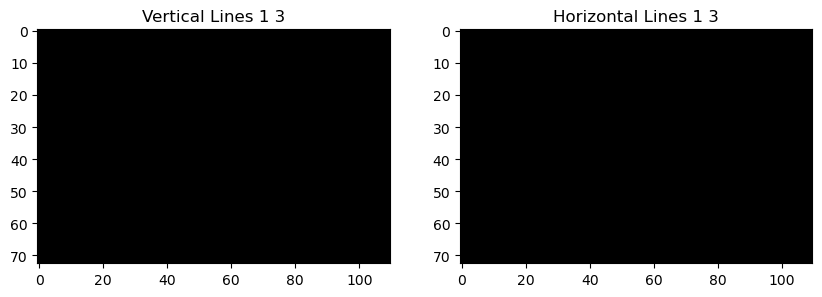

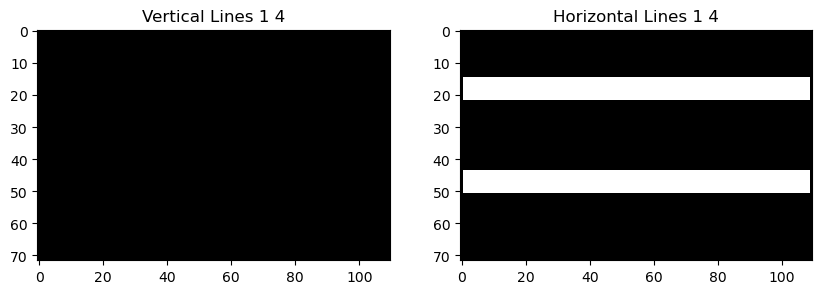

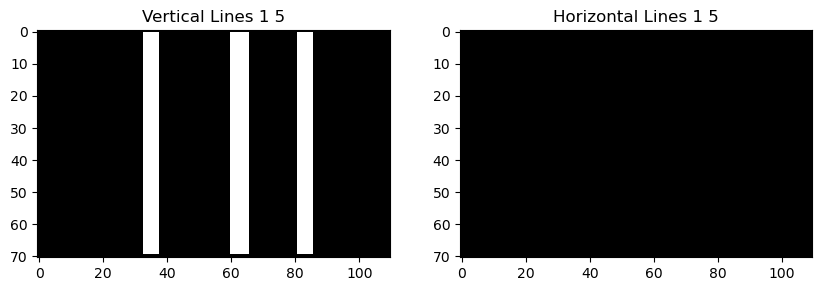

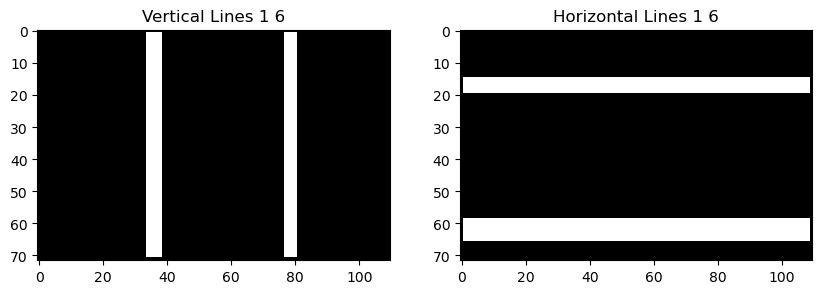

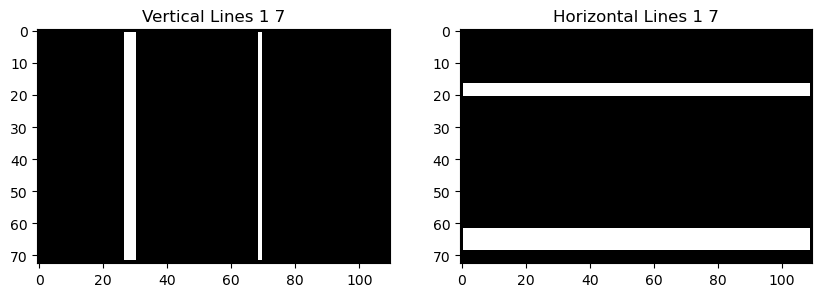

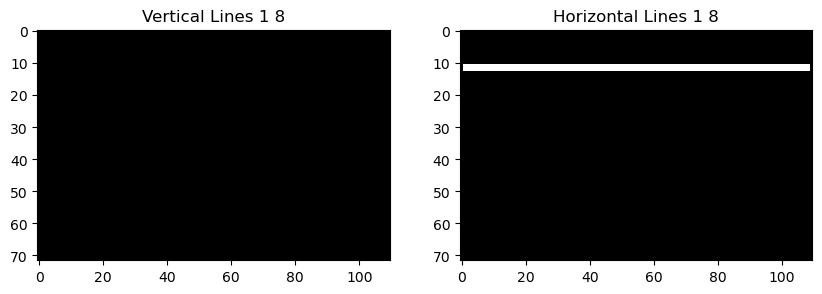

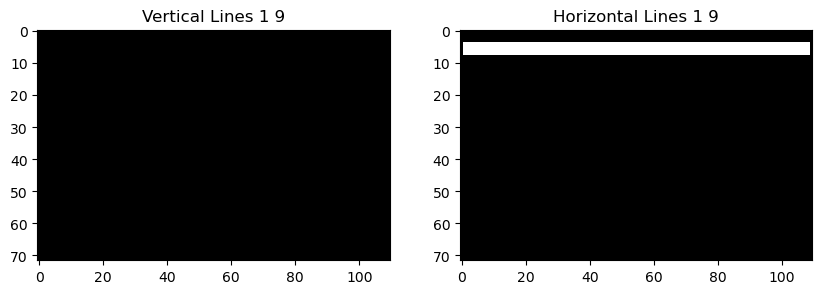

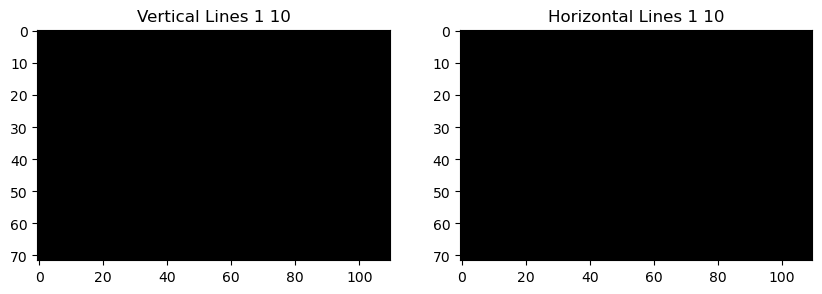

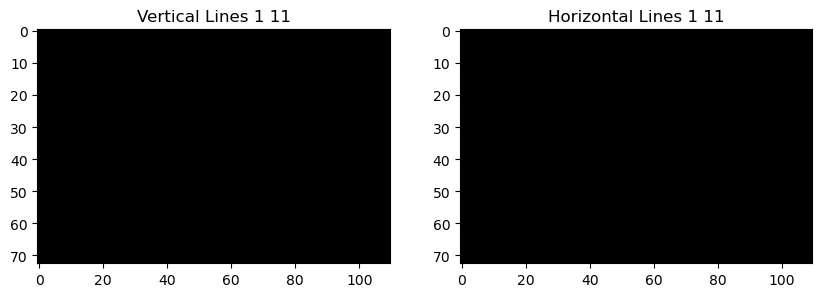

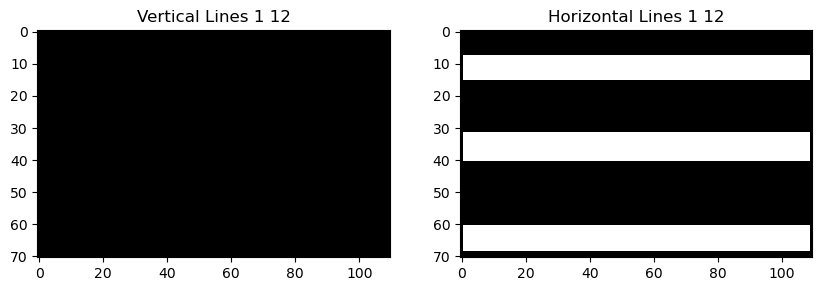

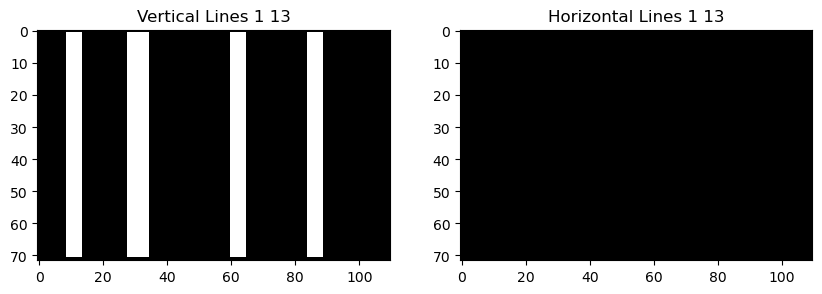

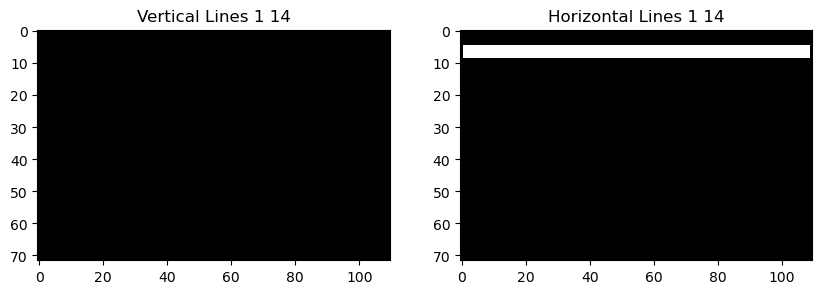

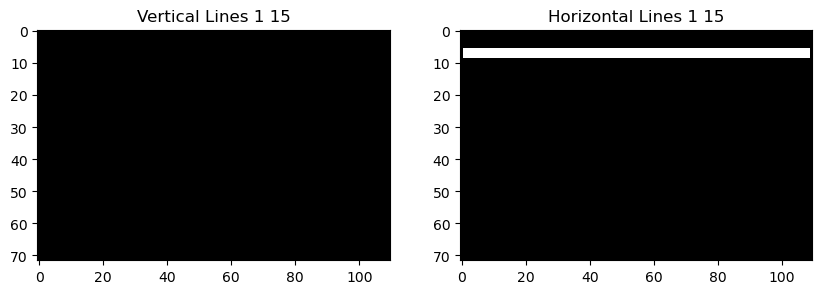

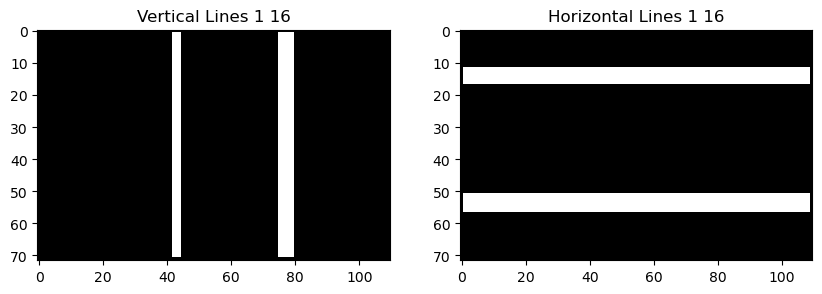

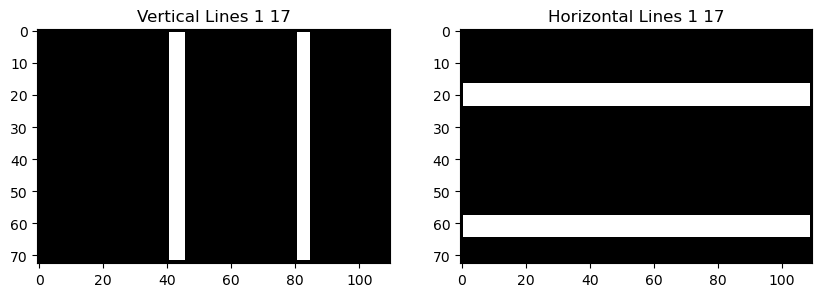

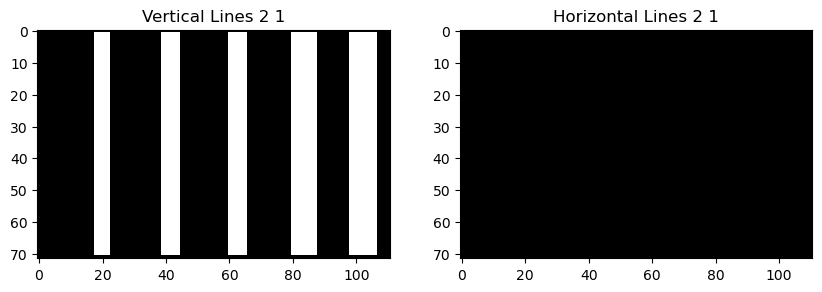

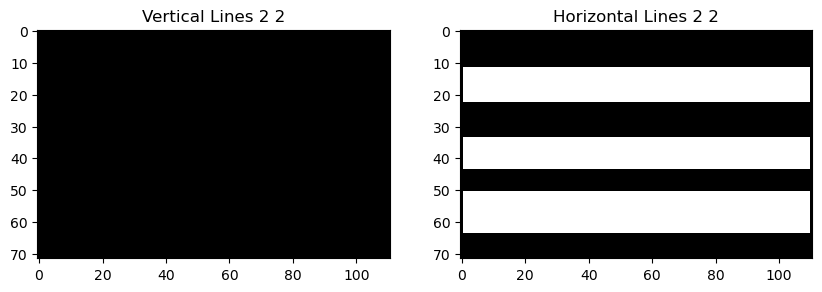

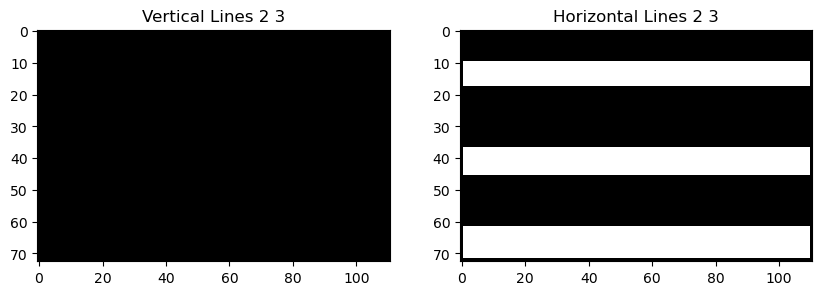

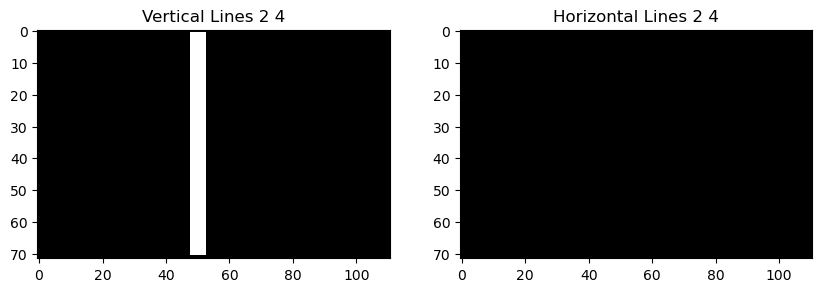

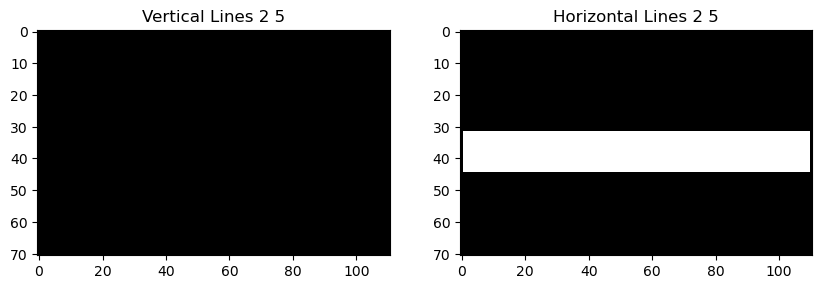

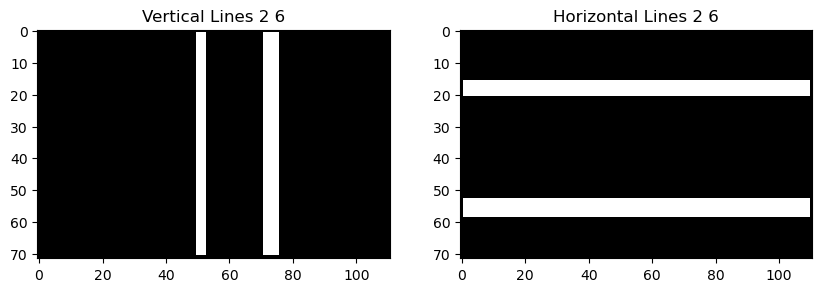

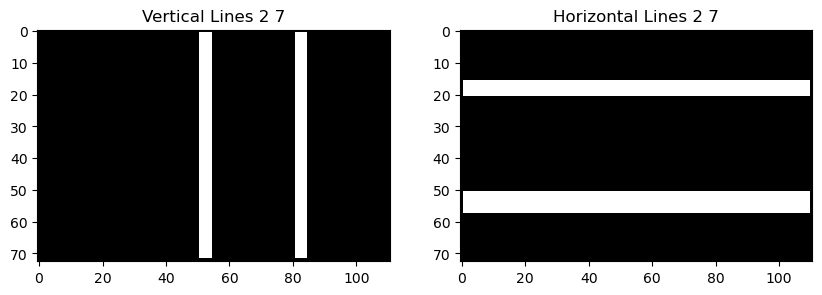

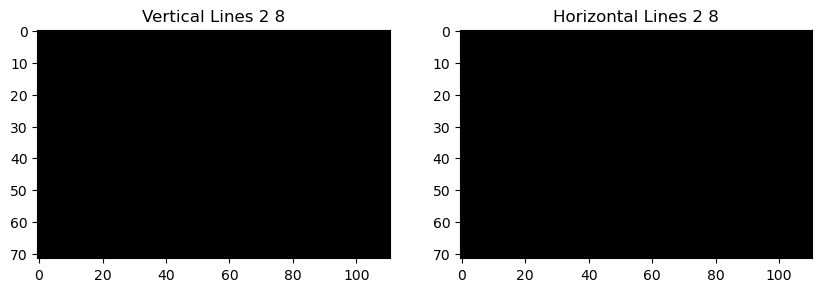

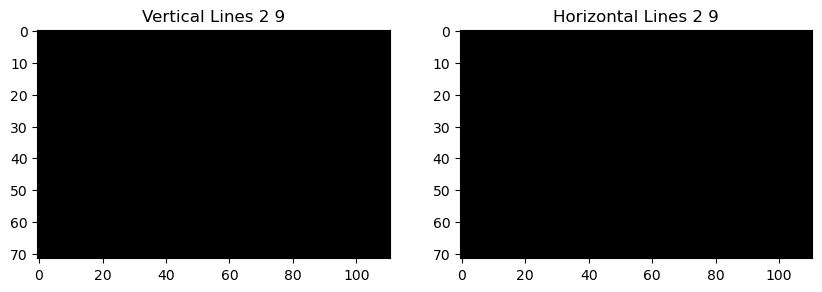

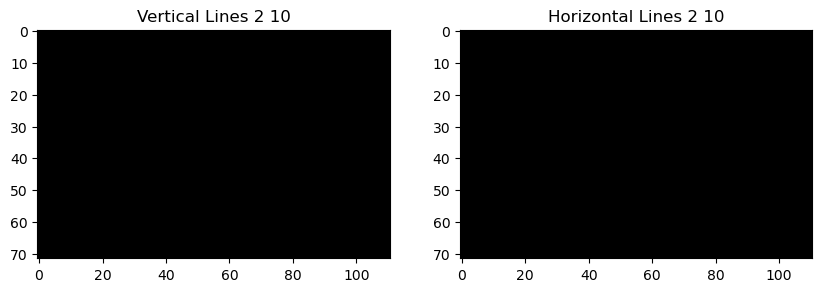

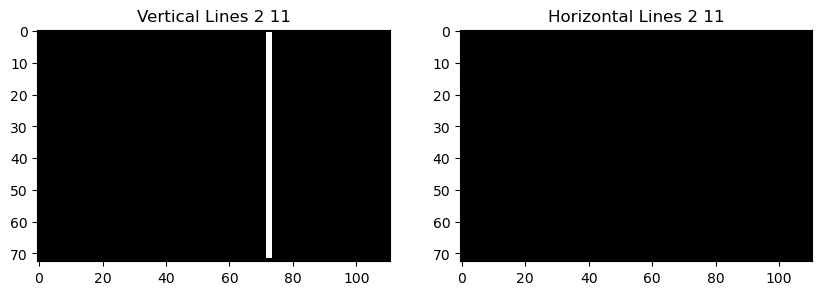

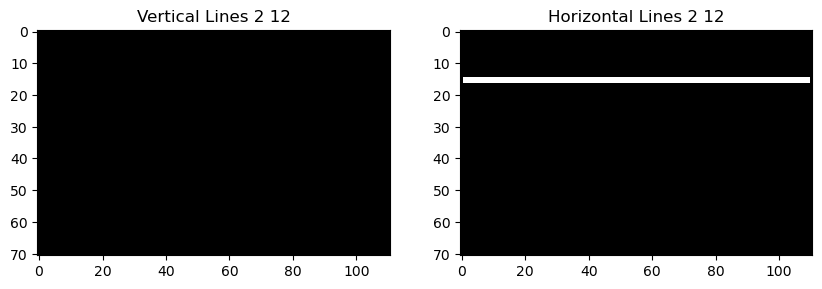

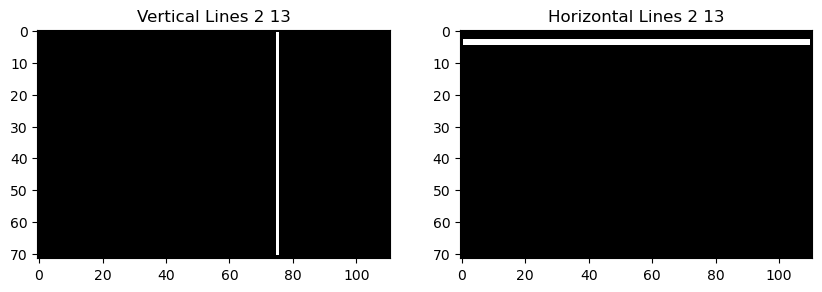

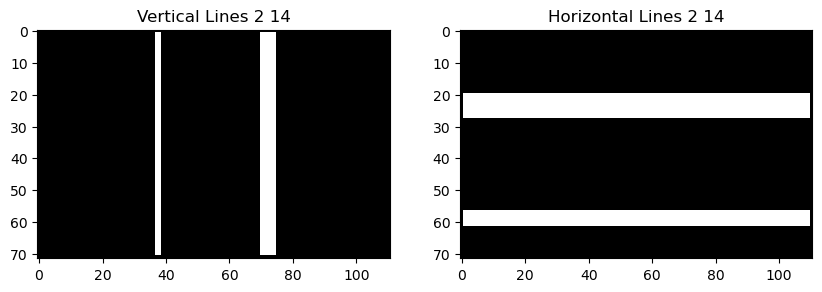

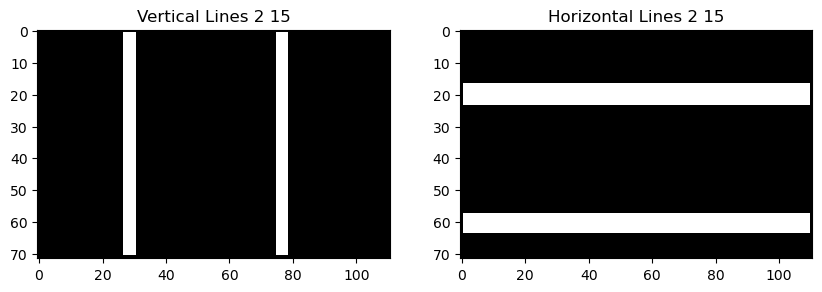

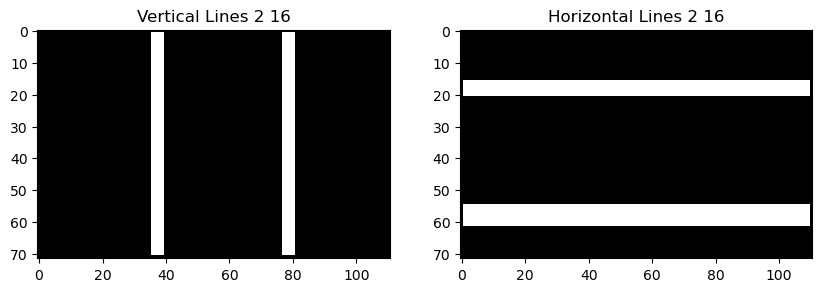

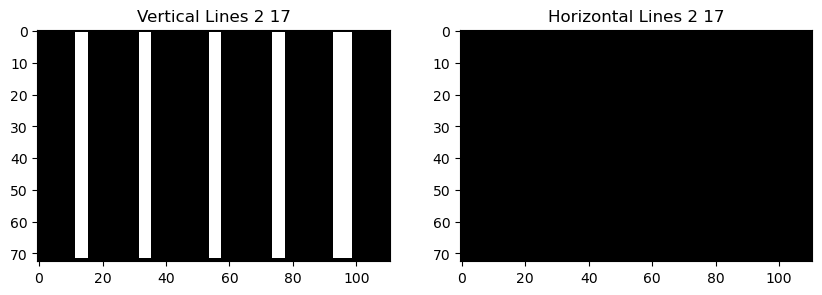

In [561]:
# Detect the vertical lines through repeated binary erosion and dilation
length = Cropped_Image.shape[1]//10
vertical_kernel = np.ones((length,1), np.uint8)
horizontal_kernel = np.ones((1,length), np.uint8)

Black_List=[]
Final_Grades=np.zeros_like(Grades)


fig,ax=plt.subplots()
ax.imshow(binary,cmap=plt.cm.gray)

for col in range(1,Col_Num-3):
    for row in range(1,Row_Num):
        
       
        
        Corners = Get_Corners(Grades[col][row]).astype(int)
        Xmin = np.min(Corners,axis=0)[0]+10
        Xmax = np.max(Corners,axis=0)[0]-10
        Ymin = np.min(Corners,axis=0)[1]+10
        Ymax = np.max(Corners,axis=0)[1]-10

        # Crop the image
        Cropped_Image = binary[Xmin:Xmax,Ymin:Ymax]
        
        if len(find_contours(Cropped_Image))==0: 
             Black_List.append((col,row))
             Final_Grades[col][row]=""
             ax.plot(Grades[col,row][:,1],Grades[col,row][:,0])
        
        Vertical_Image= ~Cropped_Image.copy()
        # Erosion yields only the vertical lines and removes the cell contents.
        for i in range(4): Vertical_Image = binary_erosion(Vertical_Image, vertical_kernel)
        # Dilation extends the lines to get the full lines.
        for i in range(30): Vertical_Image = binary_dilation(Vertical_Image, vertical_kernel)

        Vertical_Image = np.pad(Vertical_Image, 1, mode='constant', constant_values=0)
        
        # Count the vertical lines --> Columns = Lines-1
        VLines=len(find_contours(Vertical_Image))
        print(f'There are {VLines} vertical')
        

        
        Horizontal_Image= ~Cropped_Image.copy()

        # Erosion yields only the vertical lines and removes the cell contents.
        for i in range(2): Horizontal_Image = binary_erosion(Horizontal_Image, horizontal_kernel)
        # Dilation extends the lines to get the full lines.
        for i in range(30): Horizontal_Image = binary_dilation(Horizontal_Image, horizontal_kernel)

        Horizontal_Image = np.pad(Horizontal_Image, 1, mode='constant', constant_values=0)
        
        Contours = find_contours(Horizontal_Image)
        HLines=len(Contours)
        print(f'There are {HLines} horizontal lines\n')
    
    
        if (HLines > 0 and VLines == 0) or (HLines == 0 and VLines > 0):
            Black_List.append((col,row))
            ax.plot(Grades[col,row][:,1],Grades[col,row][:,0])
            if HLines > 0:
                Final_Grades[col][row]=5-HLines
                
            else:
                Final_Grades[col][row]=VLines
        
        
        
        fig,(ax1,ax2)= plt.subplots(ncols=2,figsize=(10,10))
        fig.max_open_warning = False
        ax1.set_title(f"Vertical Lines {col} {row}")
        ax1.imshow(Vertical_Image,cmap=plt.cm.gray)
        ax2.set_title(f"Horizontal Lines {col} {row}")
        ax2.imshow(Horizontal_Image,cmap=plt.cm.gray)
            
    
    print(Black_List)
    print(len(Black_List))
    print(Final_Grades)
    


    


In [562]:
def load_images(dir_name, dimension=(20, 20)):
    image_dir=Path(dir_name)
    Folders=[directory for directory in image_dir.iterdir() if directory.is_dir()]
    train_img = []
    for i,direc in enumerate(Folders):
        # for file in direc.iterdir():
            l = os.listdir(direc)
            lsorted = sorted(l, key=lambda x: int(os.path.splitext(x)[0]))
            for file in lsorted:
                        img = imread(f"Data\{i}\\"+file)
                        # print(f"Data\{i}\\"+file)
                        if len(img.shape)>2:
                            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                        img_pred = cv2.resize(img, (20, 20), interpolation=cv2.INTER_AREA)
                        img_pred = np.asarray(img_pred)
                        img_pred = img_pred / 255
                       
            
                        # print("knn_sq\\"+file)    
                        # fig,ax=plt.subplots()
                        # ax.imshow(img,cmap=plt.cm.gray)
                        train_img.append(img_pred)

    X = np.array(train_img)

    return X


X = []
X = load_images("Data")
# print(X,len(X))


c:\Users\Karim Negm\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


6 18
[0.] [0.]
[0.] [0.]
[0.] [0.]
[1.] [1.]
[1.] [1.]
[0.] [0.]
[0.] [0.]
[1.] [1.]
[1.] [1.]
[1.] [1.]
[1.] [1.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[2.] [2.]
[1.] [1.]
[1.] [1.]
[1.] [1.]
[['Q1' 5 5 5 3 3 0 0 4 4 5 5 2 4 4 4 0 0]
 ['Q2' 5 2 2 1 4 0 0 5 5 5 1 4 'R' 0 0 0 5]]


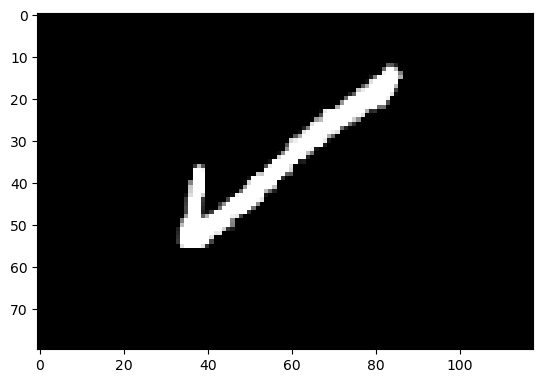

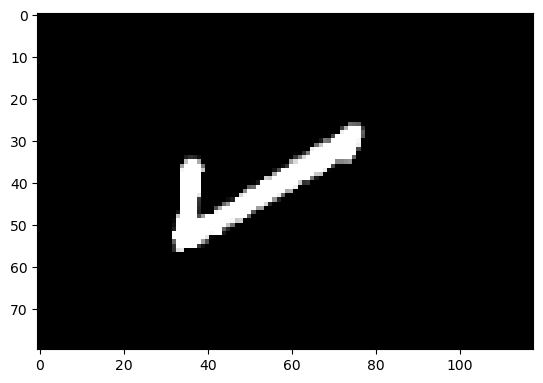

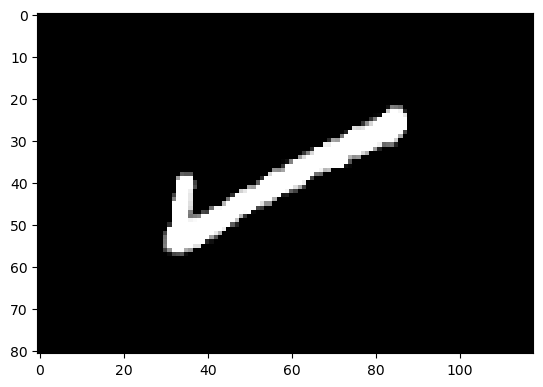

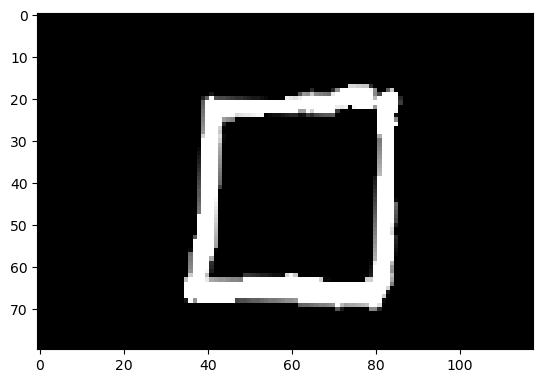

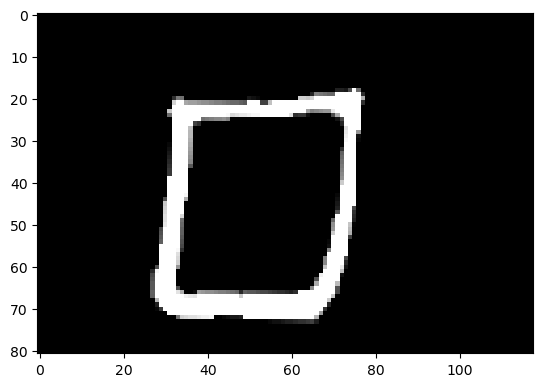

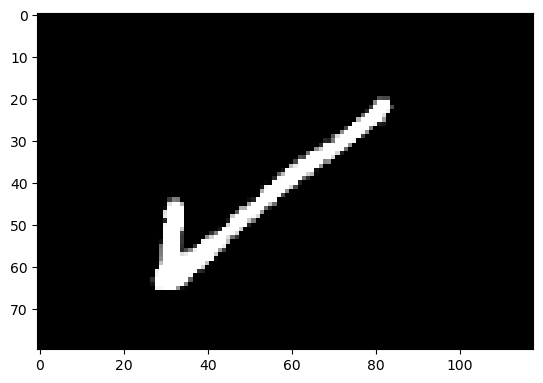

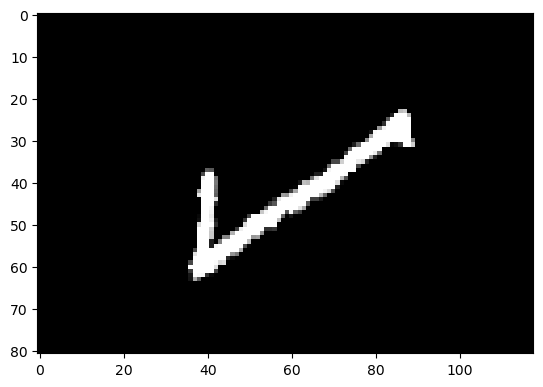

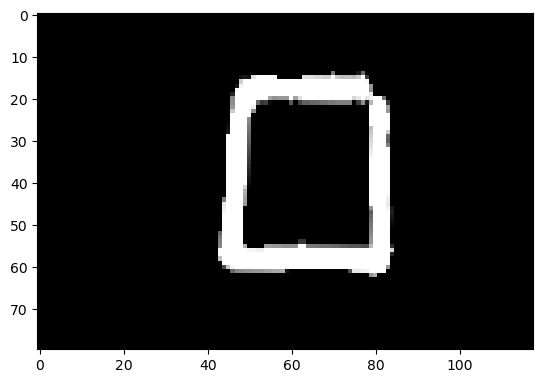

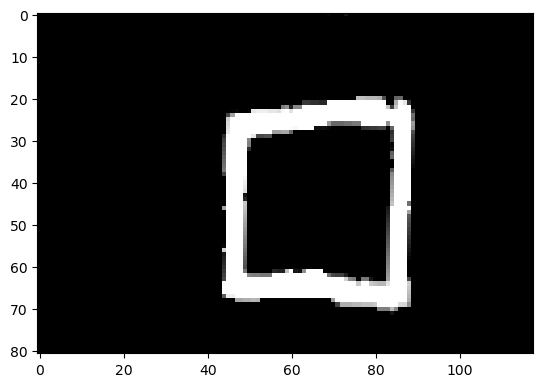

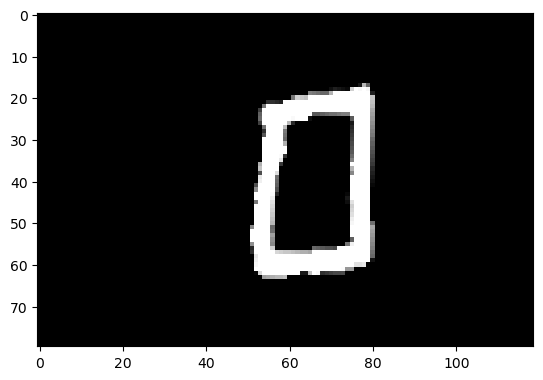

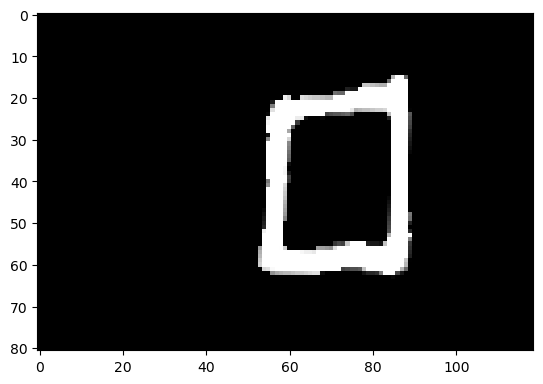

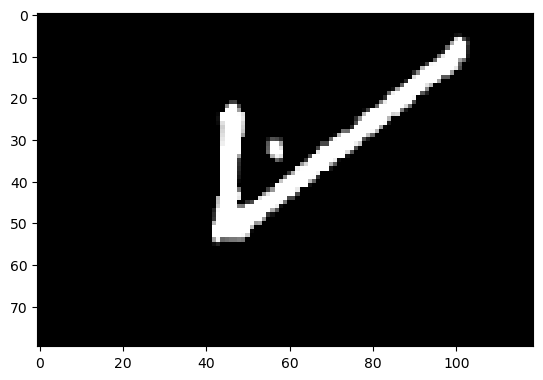

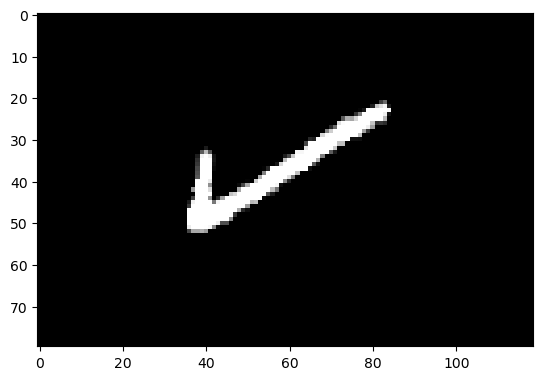

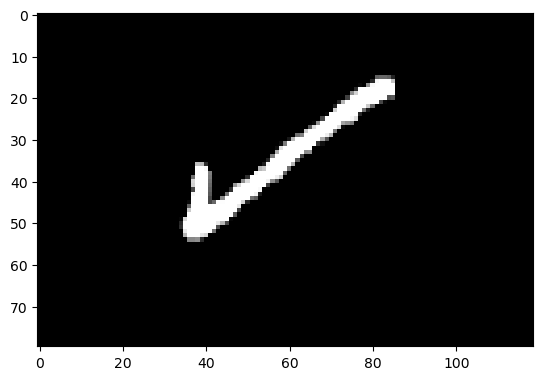

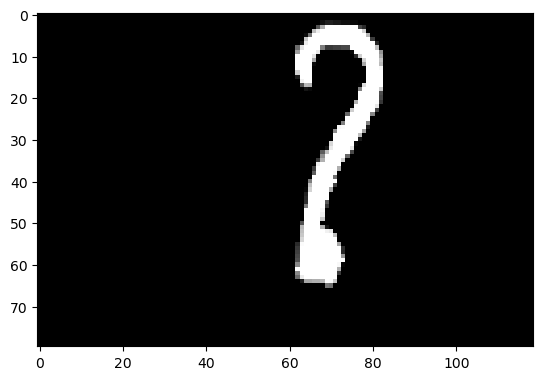

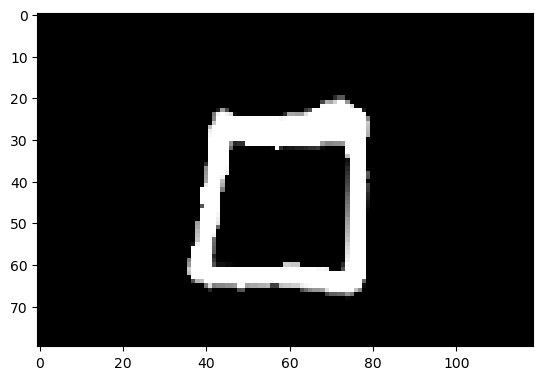

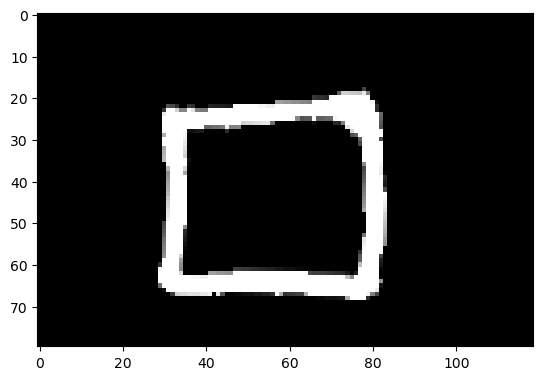

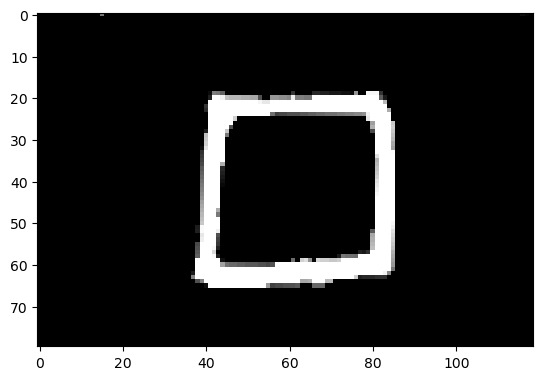

In [563]:

def KNN(train, test, label):
        y= np.array(label.reshape(len(label)))
        distance = [] 
        data = []
        for i in train:
            dist = 0
            for j in range(20*20): 
               dist += (test[0][j]-i[j])**2
            dist = np.sqrt(dist)
            distance.append(dist)
            data.append(i)
        distance = np.array(distance)
        data = np.array(data)
        index_dist = distance.argsort()
        data = data[index_dist]
        y=y[index_dist]
        neighbors = data[:3]
        labely=y[:4] #4 neighbors 
        g=stats.mode(labely) # most voted neighbor 
        ans=g[0]
        return ans

warnings.simplefilter(action='ignore', category=FutureWarning)

# KNN Output Predictions
    # Check    ✅ --> 0
    # Square   🟥 --> 1
    # Question ❓ --> 2
    # Empty Cell  --> 3

y0 = np.zeros(118)
y1 = np.ones(53)
y2=np.full(85,2)


y = []
y = np.concatenate((y0,y1, y2), axis=0)
l=y
X = X.reshape(X.shape[0], -1)
model = KNeighborsClassifier(n_neighbors=3)
y = y.reshape(y.shape[0], -1)
model.fit(X,y)


ax1.plot(Grades[col,row][:,1],Grades[col,row][:,0])
print(Col_Num,Row_Num )
for j in range (1,Col_Num-3):
    for i in range (1,Row_Num):
        if (j,i) in Black_List:            
            continue
        Corners = Get_Corners(Grades[j,i]).astype(int)
        Xmin = np.min(Corners,axis=0)[0]+5
        Xmax = np.max(Corners,axis=0)[0]-5
        Ymin = np.min(Corners,axis=0)[1]+5
        Ymax = np.max(Corners,axis=0)[1]-5
        Cropped_Image = binary[Xmin:Xmax,Ymin:Ymax]
        if Cropped_Image.dtype == bool:
            Cropped_Image = Cropped_Image* 255
        
        Cropped_Image = Cropped_Image.astype(np.uint8)
        # print(Cropped_Image)
        img = ~Cropped_Image.copy()
        fig,ax=plt.subplots()
        ax.imshow(img,cmap=plt.cm.gray)
        if len(img.shape)>2:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # img = binary_dilation(img).astype(np.uint8)
        # img=median(img)
        img_pred = cv2.resize(img, (20, 20), interpolation=cv2.INTER_AREA)
        img_pred = np.asarray(img_pred)

        # img_pred = img_pred / 255
        img_pred = np.reshape(img_pred,(1,20*20))
        fig.max_open_warning = False
        

        myKnn=KNN(X, img_pred, y)
        predicted= model.predict(img_pred) 
        if predicted == 0:
            Final_Grades[j][i]=5
        elif predicted == 1:
            Final_Grades[j][i]=0
        elif predicted == 2:
            Final_Grades[j][i]="R"
        print(predicted, myKnn)

Final_Grades[1][0]="Q1"
Final_Grades[2][0]="Q2"
print(Final_Grades[1:3])



In [564]:
# import pandas as pd

# fields= [f"{i+1}" for i in range(Col_Num-3)]
# df = pd.DataFrame(fields)
# writer = pd.ExcelWriter('Table.xlsx', engine='xlsxwriter')
# df.to_excel(writer, sheet_name='Sheet1', startrow=1, header=False, index=False)
# df.
    